In [259]:
## Create *known* parameters
import torch
weight=0.7
bias=0.3

## Create 
start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [260]:
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [261]:
import matplotlib.pyplot as plt
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plot training data, test data and compare predictions
    """
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")

    # Plot test data in green
    plt.scatter(test_data,test_labels,c="g",s=4,label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")

    # Show the legend
    plt.legend(prop={"size":14});

In [262]:
# Create Linear regression model class
import torch
from torch import nn
class LinearRegressionModel(nn.Module):   ## <- almost everything in Pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        ## initialize model parameters
        self.weights=nn.Parameter(torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float))
        
        self.bias=nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))
        ## forward() defines the computation in the model
    
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.weights*x+self.bias

### Pytorch model building essentials

*torch.nn - contains all of the buildings for computational graphs 
*torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
*torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward
*torch.optim - this is where the optimizers in PyTorch live, they will help us with gradient descent
*def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in forward computation

### Checking the contents of our PyTorch model

Now we've created a model,let's see what's inside....

So we can check our model parameters or what's inside our model using '.parameters()'

In [263]:
## Create a random seed
torch.manual_seed(42)

## Create an instance of the model (this is a subclass of nn.Module)
model_0=LinearRegressionModel()

## Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [264]:
## List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making prediction using 'torch.inference_mode()'

To check our model's predictive power, let's see how well it predicts 'y_test' based on 'x_test'

When we pass our data through our model, it's going to run it through the foward() method.

In [265]:
X_test,y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [266]:
# Make predictions with model
with torch.inference_mode():
    y_preds=model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [267]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

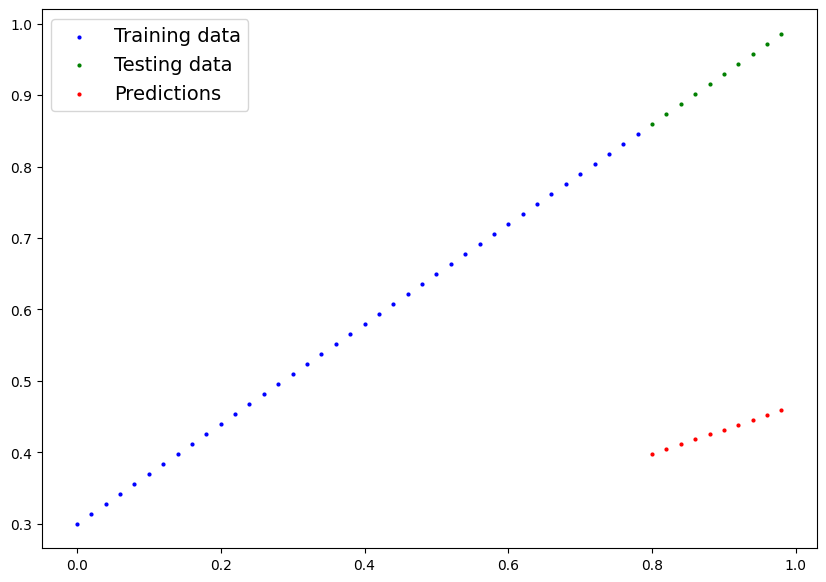

In [268]:
plot_predictions(predictions=y_preds)

## 3. Train model 

The whole idea of training is for a model to move from some *unkown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are is to use a loss function.

*Note : Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

* **Loss functions** :- A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function. 

* * Inside the optimizer you'll often have to set two parameters:
* * params - the model parameters you'd like to optimize,for example params=model_0.parameters()
* * lr(learning rate)- the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step ( a small lr results in small changes, a large lr results in large changes) 

And specially for PyTorch, we need: 
* A training loop 
* A testing loop

In [269]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [270]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [271]:
## setup a loss function 
loss_fn=nn.L1Loss()

## setup an optimizer
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data
1. Forward pass (this involves data moving through our model's 'forward' function) to make predictions on data- also called forward propogration
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
5. Optimizer step- try and improve our loss

In [298]:
# An epoch is one loop through the data .....( this is a hyperparameter because we've set it ourselves)
epochs=10

### Training
## 0. Loop through the data
epoch_count=[]
loss_values=[]
test_loss_values=[]

### Training
# 0. Loop through the data
for epoch in range(1,epochs+1):
    ## Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    #1. Forward pass
    y_pred=model_0(X_train)

    #2. Calculate the loss
    loss=loss_fn(y_pred,y_train)
    print(f"Loss: {loss}")
    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    #5. Step the optimizer (perform gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing
    with torch.inference_mode(): ## turns off gradient tracking
        #1. Do the forward pass
        test_pred=model_0(X_test)

        #2. Calculate the loss 
        test_loss=loss_fn(test_pred,y_test)

    if epoch %10==0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss_values)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    ## Print out model state_dict()
    print(model_0.state_dict())

Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
Epoch: 10 | Loss: 0.0025885067880153656 | Test loss: 0.008447891101241112
OrderedDict({'weights': tensor

In [299]:
epoch_count, loss_values, test_loss_values

([10], [0.0025885067880153656], [[...]])

In [300]:
with torch.inference_mode():
    y_preds_new=model_0(X_test)

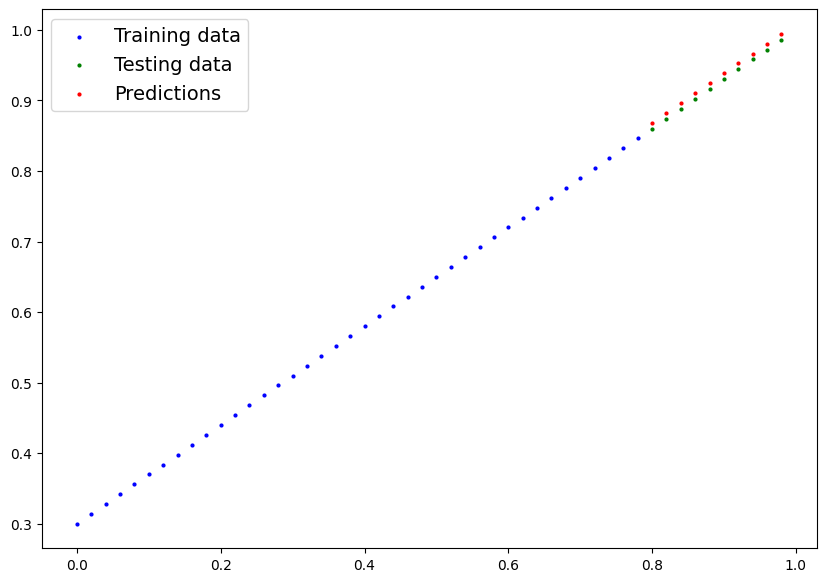

In [301]:
plot_predictions(predictions=y_preds_new)

In [302]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [303]:
weight,bias

(0.7, 0.3)

### Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. 'torch.save()' - allows you to save a PyTorch in Python pkl format
2. 'torch.load()' - allows you to load a saved PyTorch object
3. "torch.nn.Module.load_state_dict()" - this allows to load a model's saved state dictionary 

In [305]:
## Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
model_name="01_pytorch_workflow_model_0.pth"
model_save_path=model_path/model_name

# 3. Save the model's state_dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model_0.state_dict(),
           f=model_save_path)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Loading a Pytorch Model

Since we saved our model's 'state_dict()' rather than the entire model, we'll create a new instance of our model class and load the saved 'state_dict()' into that


In [306]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [311]:
## To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0=LinearRegressionModel()

## Load the saved state_dict of model_o (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=model_save_path))

<All keys matched successfully>

In [310]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [313]:
# Make some predictions with our loaded model 
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds=loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [315]:
## Make some models preds
model_0.eval()
with torch.inference_mode():
    y_preds=model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [316]:
# compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])